In [80]:
# pip install optuna

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
import optuna


In [83]:
df = pd.read_csv('input/spotify_songs.csv', sep=',')

songs = df[['playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
print(songs.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   playlist_genre    32833 non-null  object 
 1   danceability      32833 non-null  float64
 2   energy            32833 non-null  float64
 3   key               32833 non-null  int64  
 4   loudness          32833 non-null  float64
 5   mode              32833 non-null  int64  
 6   speechiness       32833 non-null  float64
 7   acousticness      32833 non-null  float64
 8   instrumentalness  32833 non-null  float64
 9   liveness          32833 non-null  float64
 10  valence           32833 non-null  float64
 11  tempo             32833 non-null  float64
 12  duration_ms       32833 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 3.3+ MB
None


In [84]:
songs.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [85]:
# Remove duplicates
duplicates = songs.duplicated()
print("Number of duplicate rows: ", duplicates.sum())

songs_no_duplicates = songs.drop_duplicates()


Number of duplicate rows:  3041


We have performed tests with and without removing duplicated rows. Turns out leaving duplicates yields much better result (almost 5% improvement for some models).

In [86]:
print("Total number of songs: ", len(songs))
print(songs['playlist_genre'].value_counts())

Total number of songs:  32833
playlist_genre
edm      6043
rap      5746
pop      5507
r&b      5431
latin    5155
rock     4951
Name: count, dtype: int64


In [87]:
min = songs['playlist_genre'].value_counts().min()
# Take only min songs from each genre
songs_grouped = songs.groupby('playlist_genre').head(min)

In [88]:
map_genres = {genre: i for i, genre in enumerate(songs_grouped['playlist_genre'].unique())}
map_genres 

{'pop': 0, 'rap': 1, 'rock': 2, 'latin': 3, 'r&b': 4, 'edm': 5}

In [89]:
songs_data_non_normalized = songs_grouped.drop('playlist_genre', axis=1)
songs_target = songs_grouped['playlist_genre']
songs_target = songs_target.map(map_genres)

# Normalize data to 0-1 range
songs_data = (songs_data_non_normalized - songs_data_non_normalized.min()) / (songs_data_non_normalized.max() - songs_data_non_normalized.min())

songs_data_train, songs_data_test, songs_target_train, songs_target_test = train_test_split(songs_data, songs_target, test_size=0.3, random_state=0)
songs_data_test, songs_data_val, songs_target_test, songs_target_val = train_test_split(songs_data_test, songs_target_test, test_size=0.5, random_state=0)

print("Training set size: ", len(songs_data_train))
print("Test set size: ", len(songs_data_test))
print("Validation set size: ", len(songs_data_val))

Training set size:  20794
Test set size:  4456
Validation set size:  4456


In [90]:
# only train-test split (for cross validation)
songs_data_train2, songs_data_test2, songs_target_train2, songs_target_test2 = train_test_split(songs_data, songs_target, test_size=0.15, random_state=0)

print("Training set size: ", len(songs_data_train2))
print("Test set size: ", len(songs_data_test2))

Training set size:  25250
Test set size:  4456


# Data analysis

In [91]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms']

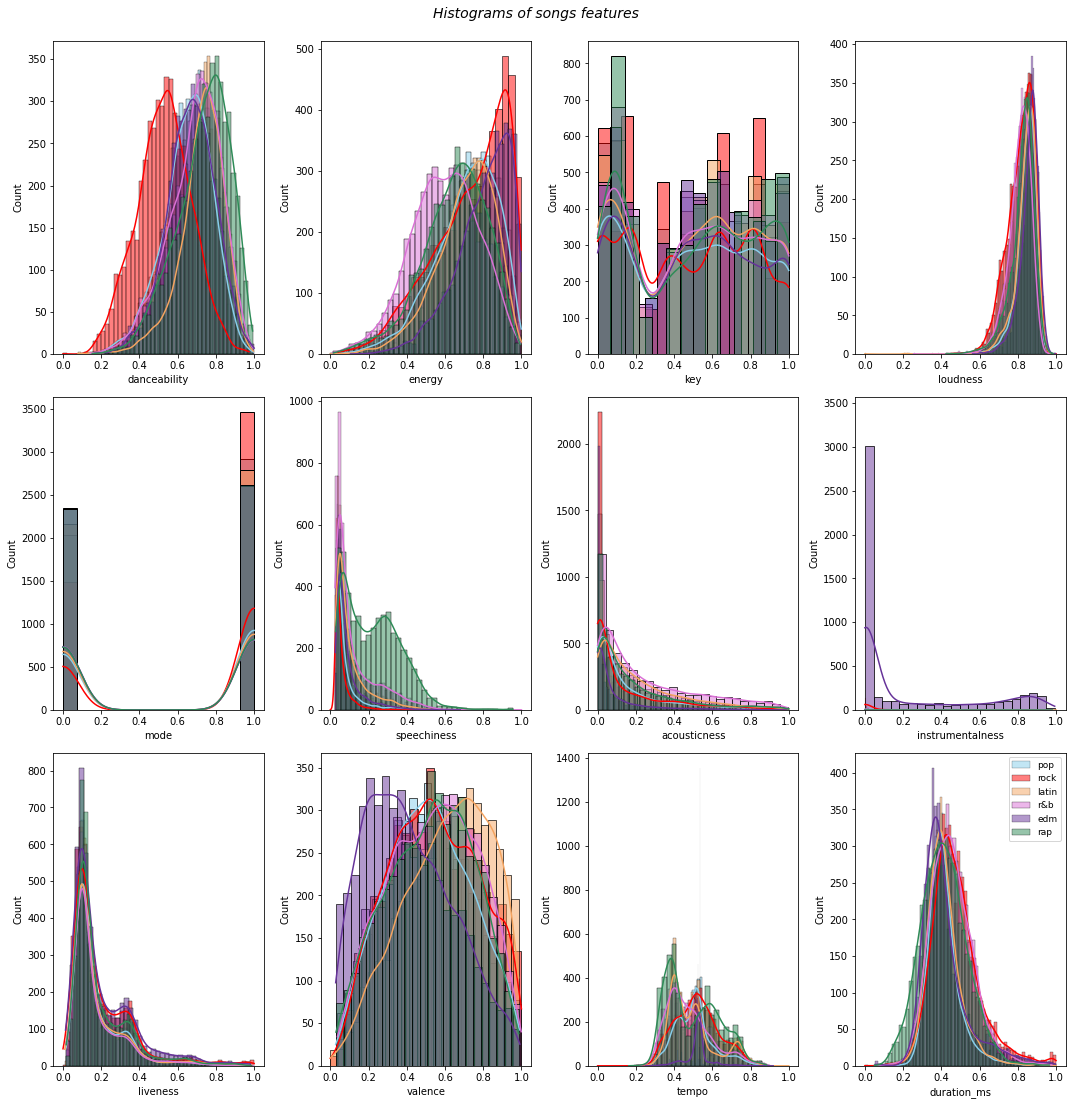

In [22]:
# normalized data
songs_data_and_target = songs_data.copy()
songs_data_and_target['playlist_genre'] = songs_grouped['playlist_genre']
pop_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='pop']
rock_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='rock']
latin_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='latin']
r_and_b_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='r&b']
edm_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='edm']
rap_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='rap']

num=0
for col in cols:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]
    #sns.set(style="darkgrid")

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)

plt.tight_layout()
# general title
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='9') #bbox_to_anchor=(1, 0)
#sns.move_legend(loc="lower center", bbox_to_anchor=(.5, 0), ncol=6, title=None, frameon=False)
plt.show()

conclusions?

c:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


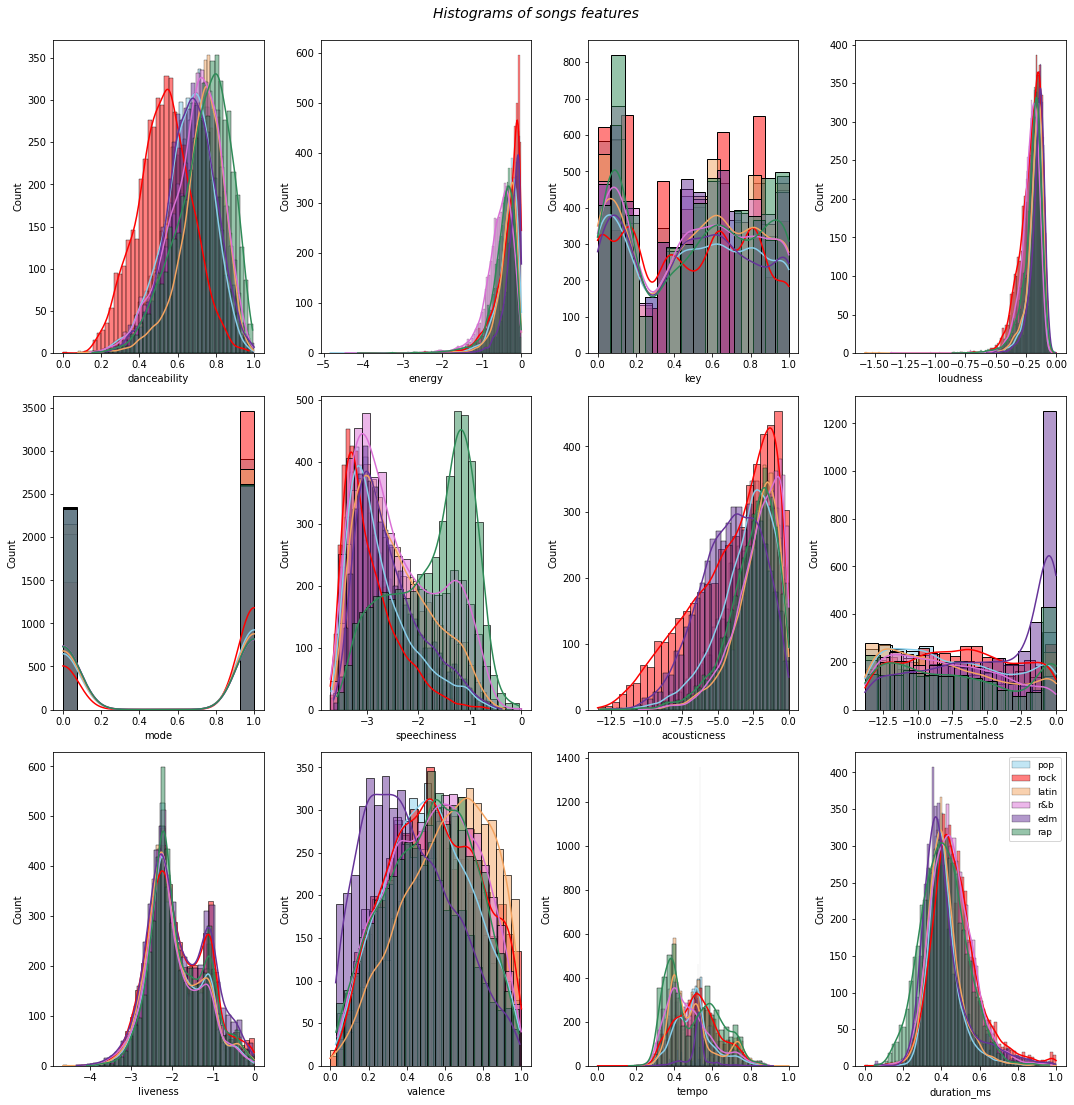

In [13]:
# normalized data + log transformation
songs_data_and_target = songs_data.copy()

songs_data_and_target['energy'] = np.log(songs_data_and_target['energy'])
songs_data_and_target['loudness'] = np.log(songs_data_and_target['loudness'])
songs_data_and_target['speechiness'] = np.log(songs_data_and_target['speechiness'])
songs_data_and_target['acousticness'] = np.log(songs_data_and_target['acousticness'])
songs_data_and_target['instrumentalness'] = np.log(songs_data_and_target['instrumentalness'])
songs_data_and_target['liveness'] = np.log(songs_data_and_target['liveness'])

songs_data_and_target['playlist_genre'] = songs_grouped['playlist_genre']
pop_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='pop']
rock_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='rock']
latin_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='latin']
r_and_b_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='r&b']
edm_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='edm']
rap_df = songs_data_and_target[songs_data_and_target['playlist_genre']=='rap']

num=0
for col in cols:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]
    #sns.set(style="darkgrid")

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)

    # plt.yscale('log')

plt.tight_layout()
# general title
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='9') #bbox_to_anchor=(1, 0)
#sns.move_legend(loc="lower center", bbox_to_anchor=(.5, 0), ncol=6, title=None, frameon=False)
plt.show()

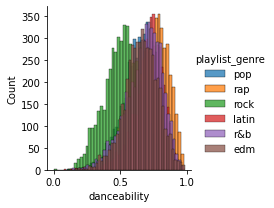

In [17]:
# different way to do the histogram (it is here just in case I want to change sth)
g = sns.FacetGrid(songs_grouped, hue="playlist_genre")
g.map(sns.histplot, "danceability") # kde=True
g.add_legend()

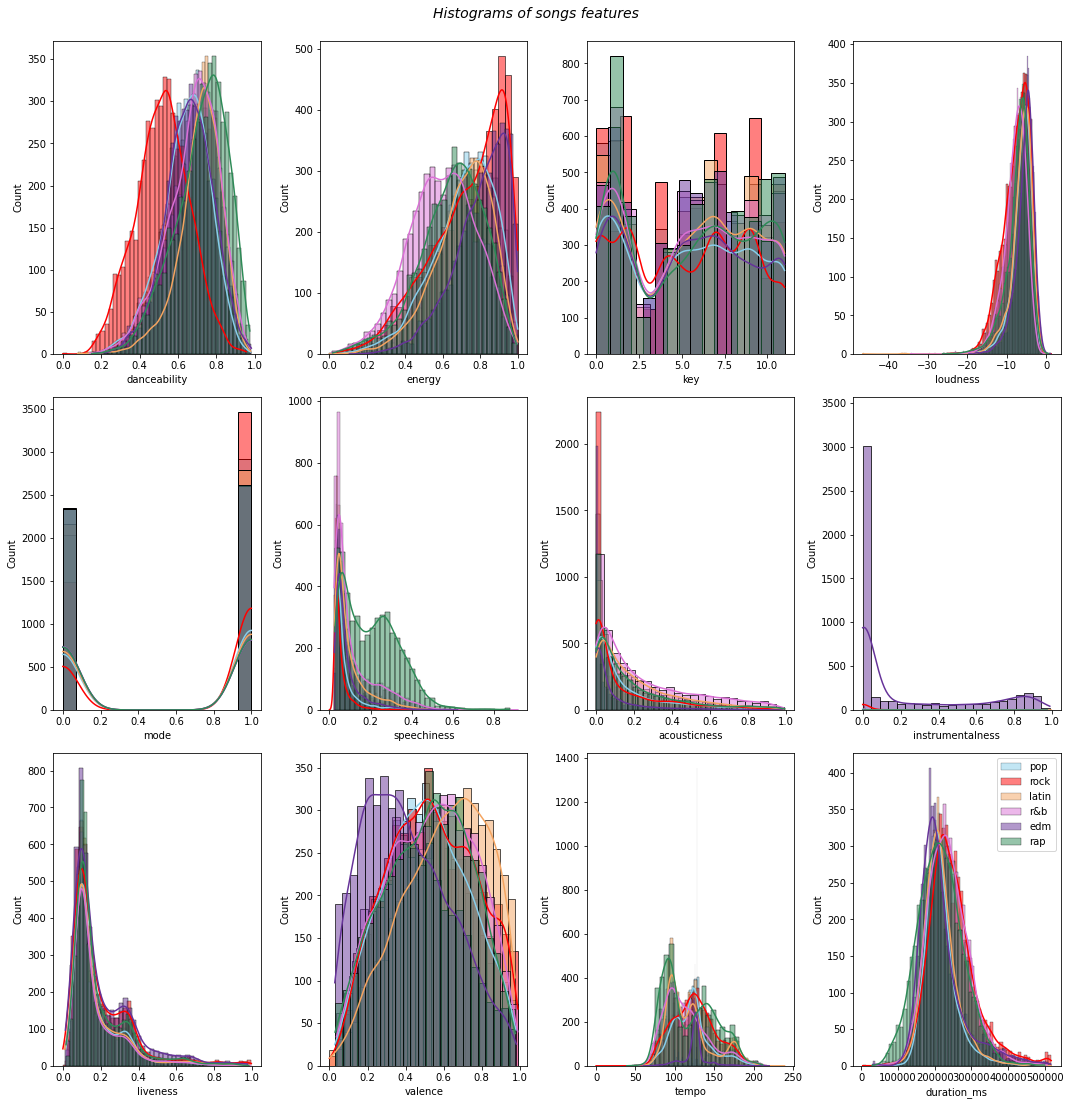

In [12]:
# without normalization
pop_df = songs_grouped[songs_grouped['playlist_genre']=='pop']
rock_df = songs_grouped[songs_grouped['playlist_genre']=='rock']
latin_df = songs_grouped[songs_grouped['playlist_genre']=='latin']
r_and_b_df = songs_grouped[songs_grouped['playlist_genre']=='r&b']
edm_df = songs_grouped[songs_grouped['playlist_genre']=='edm']
rap_df = songs_grouped[songs_grouped['playlist_genre']=='rap']

num=0
for col in cols:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]
    #sns.set(style="darkgrid")

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)
    
plt.tight_layout()
# general title
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='10')
plt.show()

# Models

## KNeighborsClassifier

In [27]:
# KNeighborsClassifier
results = []
for k in tqdm(np.arange(1,35)):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(songs_data_train, songs_target_train)

    y_pred = knn_model.predict(songs_data_val)
    accuracy = accuracy_score(songs_target_val, y_pred)
    results.append({'k':k, 'accuracy': accuracy})
                   
results_df = pd.DataFrame(results)
results_df.sort_values('accuracy', ascending=False)

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:50<00:00,  1.50s/it]


,k,accuracy
24,25,0.471050
27,28,0.470601
21,22,0.470601
20,21,0.470601
30,31,0.469928
32,33,0.469704
26,27,0.469704
22,23,0.469704
31,32,0.469479
33,34,0.468806


In [28]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=25)
knn_model.fit(songs_data_train, songs_target_train)
y_pred = knn_model.predict(songs_data_test)
accuracy = accuracy_score(songs_target_test, y_pred)
print(accuracy)

0.47172351885098746


In [40]:
# cross validation
res = []
for k in np.arange(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    er = cross_val_score(knn_model,songs_data_train2,songs_target_train2,cv=5)
    res.append({'K':k, 'err_rate': er})

In [43]:
results = list(map(lambda x: (x['K'], x['err_rate'].mean()), res))
results_df = pd.DataFrame(results)
results_df.loc[results_df[1]==results_df[1].max()]

,0,1
22,23,0.466614


In [44]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=23)
knn_model.fit(songs_data_train2, songs_target_train2)
y_pred = knn_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)
print(accuracy)

0.46970377019748655


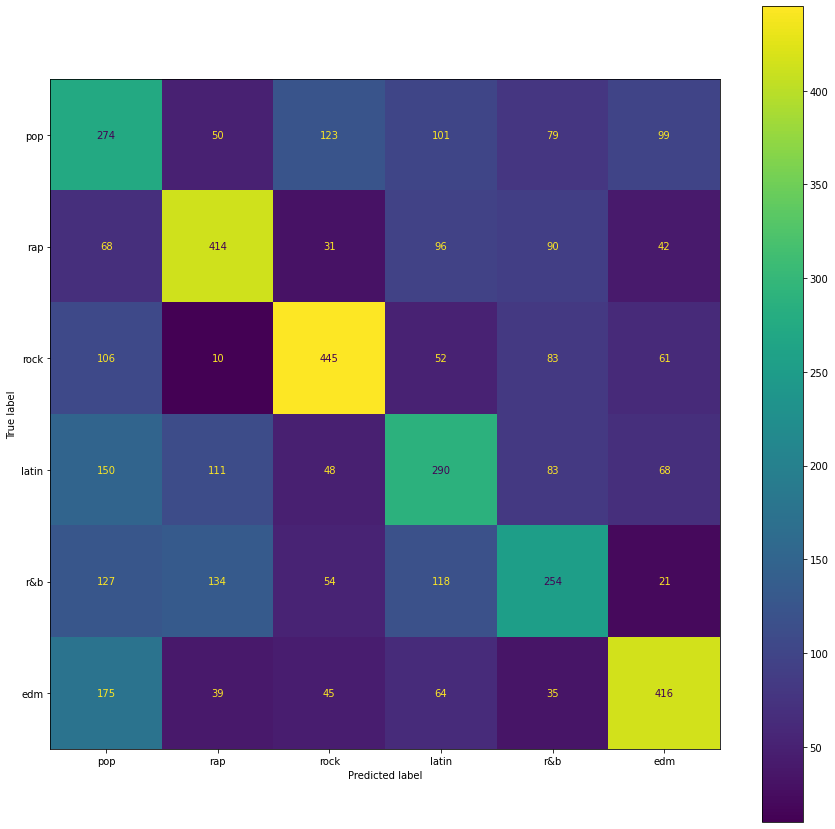

In [50]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

In [ ]:
# optuna
# https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
# https://medium.com/@iqra.bismi/hyper-parameter-tuning-of-machine-learning-models-using-optuna-f1905547937f

### KNN on not normalized data

In [15]:
songs_data_train_nn, songs_data_test_nn, songs_target_train_nn, songs_target_test_nn = train_test_split(songs_data_non_normalized, songs_target, test_size=0.3, random_state=0)
songs_data_test_nn, songs_data_val_nn, songs_target_test_nn, songs_target_val_nn = train_test_split(songs_data_test_nn, songs_target_test_nn, test_size=0.5, random_state=0)

In [16]:
results = []
for k in tqdm(np.arange(1,35)):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(songs_data_train_nn, songs_target_train_nn)

    y_pred = knn_model.predict(songs_data_val_nn)
    accuracy = accuracy_score(songs_target_val_nn, y_pred)
    results.append({'k':k, 'accuracy': accuracy})
                   
results_df = pd.DataFrame(results)
results_df.loc[results_df['accuracy']==results_df['accuracy'].max()]

100%|██████████| 34/34 [00:06<00:00,  5.01it/s]


,k,accuracy
0,1,0.290171


In [49]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(songs_data_train_nn, songs_target_train_nn)
y_pred = knn_model.predict(songs_data_test_nn)
accuracy = accuracy_score(songs_target_test_nn, y_pred)
print(accuracy)

0.2888240574506284


As we see, results for not normalized data are much worse.

### KNN after log transformation

In [23]:
train_log = songs_data_train2
test_log = songs_data_test2

train_log['speechiness'] = np.log(train_log['speechiness'])
train_log['acousticness'] = np.log(train_log['acousticness'])
train_log['liveness'] = np.log(train_log['liveness'])

test_log['speechiness'] = np.log(test_log['speechiness'])
test_log['acousticness'] = np.log(test_log['acousticness'])
test_log['liveness'] = np.log(test_log['liveness'])

# cross validation
res = []
for k in np.arange(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    er = cross_val_score(knn_model,train_log,songs_target_train2,cv=5)
    res.append({'K':k, 'err_rate': er})

results = list(map(lambda x: (x['K'], x['err_rate'].mean()), res))
results_df = pd.DataFrame(results)
results_df.loc[results_df[1]==results_df[1].max()]

c:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,0,1
19,20,0.40602


In [24]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(train_log, songs_target_train2)
y_pred = knn_model.predict(test_log)
accuracy = accuracy_score(songs_target_test2,y_pred)
print(accuracy)

ValueError: Input X contains infinity or a value too large for dtype('float64').

## Naive bayes classifier

In [52]:
# Naive bayes classifier
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train, songs_target_train)
y_pred = naive_bayes_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)

print(accuracy)

0.4506283662477558


In [53]:
# accuracy on test set
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train2, songs_target_train2)
y_pred = naive_bayes_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)

print(accuracy)

0.44367145421903054


Each feature has the same influence on the decision.

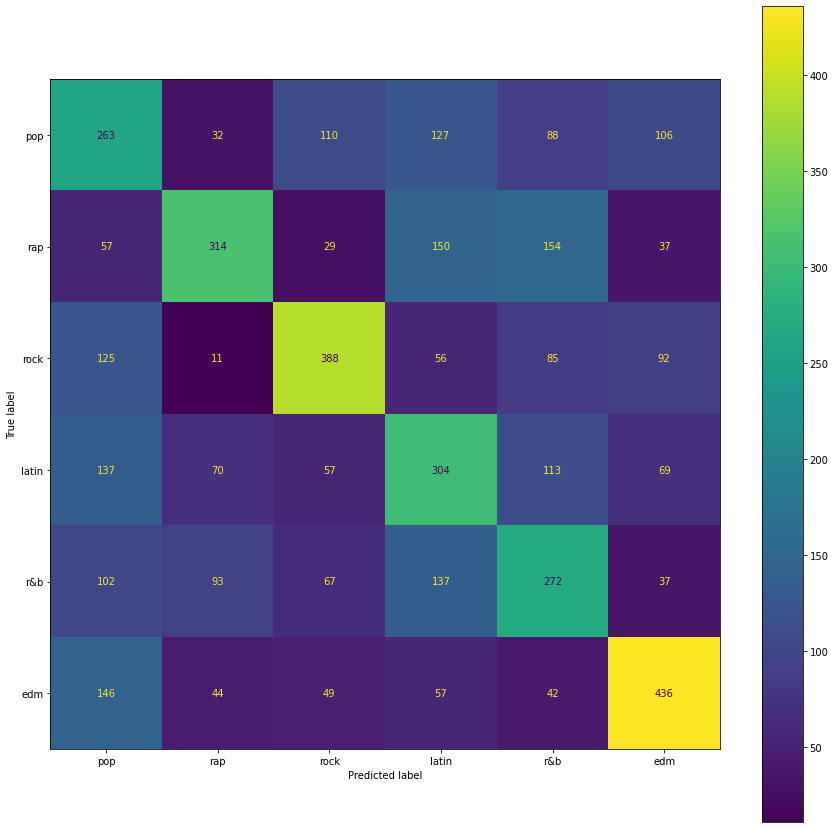

In [54]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Decision tree

In [55]:
# Decision tree
decision_tree_model = DecisionTreeClassifier()

param_grid = {
    'max_depth': [7,9,11],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [6,7,8]
}

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(songs_data_train, songs_target_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best params:", best_params)

y_pred = best_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

Best params: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 7}
0.46409335727109513


In [21]:
# feature importances
best_model.feature_importances_

array([0.17231034, 0.08777891, 0.00565915, 0.07505336, 0.00211726,
       0.19339656, 0.05211473, 0.09632431, 0.00705703, 0.06262628,
       0.17007464, 0.07548741])

In [62]:
feature_importances_dt = pd.Series(best_model.feature_importances_, index=songs_data_train.columns)
feature_importances_dt

danceability        0.172070
energy              0.085971
key                 0.005568
loudness            0.076189
mode                0.002631
speechiness         0.193384
acousticness        0.052380
instrumentalness    0.096392
liveness            0.007042
valence             0.062622
tempo               0.170064
duration_ms         0.075685
dtype: float64

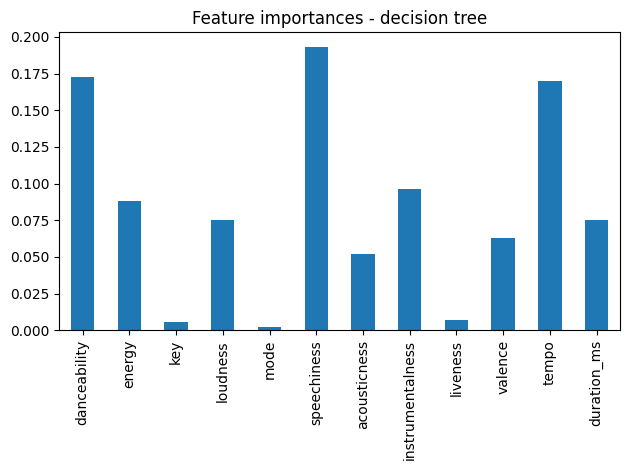

In [23]:
fig, ax = plt.subplots()
feature_importances_dt.plot.bar(ax=ax)
ax.set_title("Feature importances - decision tree")
fig.tight_layout()

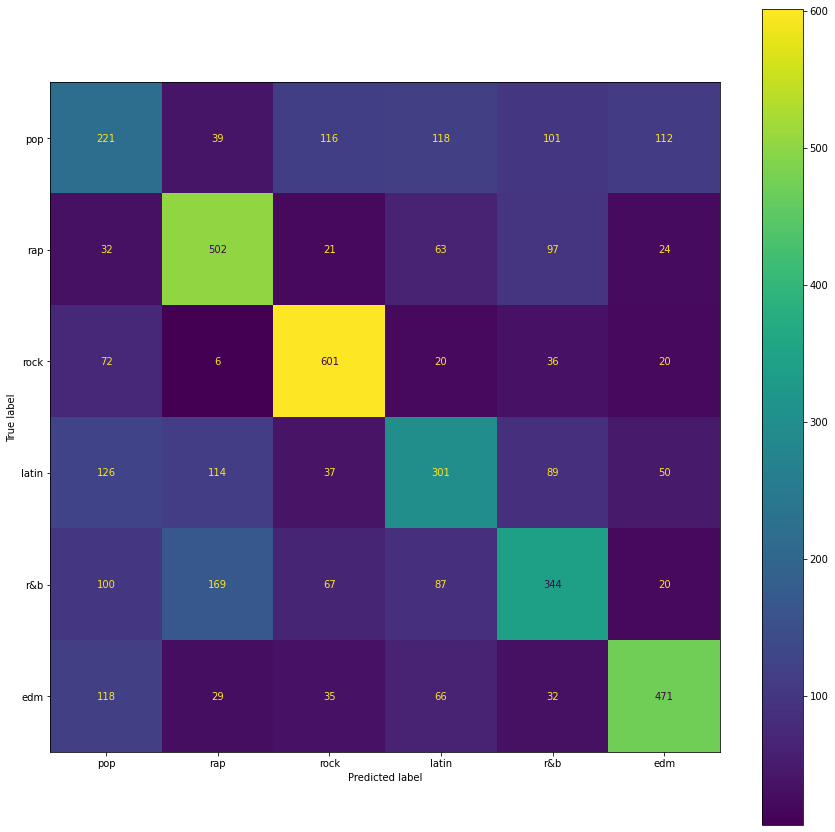

In [58]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Random forest

In [59]:
# Random forest
random_forest_model = RandomForestClassifier(n_estimators=105, random_state=42)
random_forest_model.fit(songs_data_train, songs_target_train)
y_pred = random_forest_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

# hyperparameter tunning - kilka opcji: sprawdzić najpeirw zakresy, potem albo sprynie albo random

0.547576301615799


In [25]:
# feature importances
random_forest_model.feature_importances_

array([0.11707867, 0.09406571, 0.04441596, 0.08675772, 0.01335281,
       0.12172192, 0.08929889, 0.07396318, 0.06634473, 0.08991702,
       0.1127258 , 0.09035759])

In [63]:
feature_importances_rf = pd.Series(random_forest_model.feature_importances_, index=songs_data_train.columns)
feature_importances_rf

danceability        0.117079
energy              0.094066
key                 0.044416
loudness            0.086758
mode                0.013353
speechiness         0.121722
acousticness        0.089299
instrumentalness    0.073963
liveness            0.066345
valence             0.089917
tempo               0.112726
duration_ms         0.090358
dtype: float64

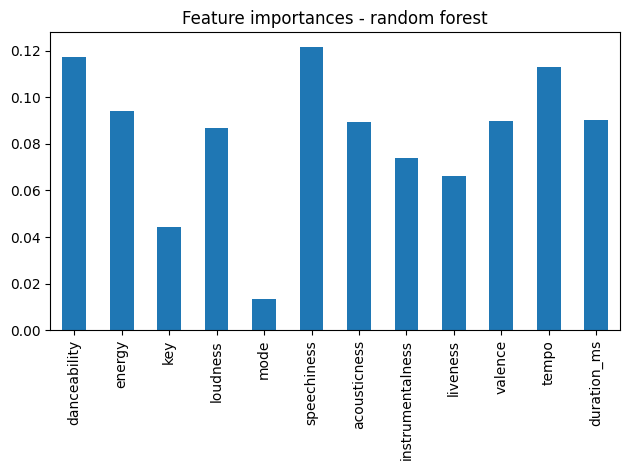

In [27]:
fig, ax = plt.subplots()
feature_importances_rf.plot.bar(ax=ax)
ax.set_title("Feature importances - random forest")
fig.tight_layout()

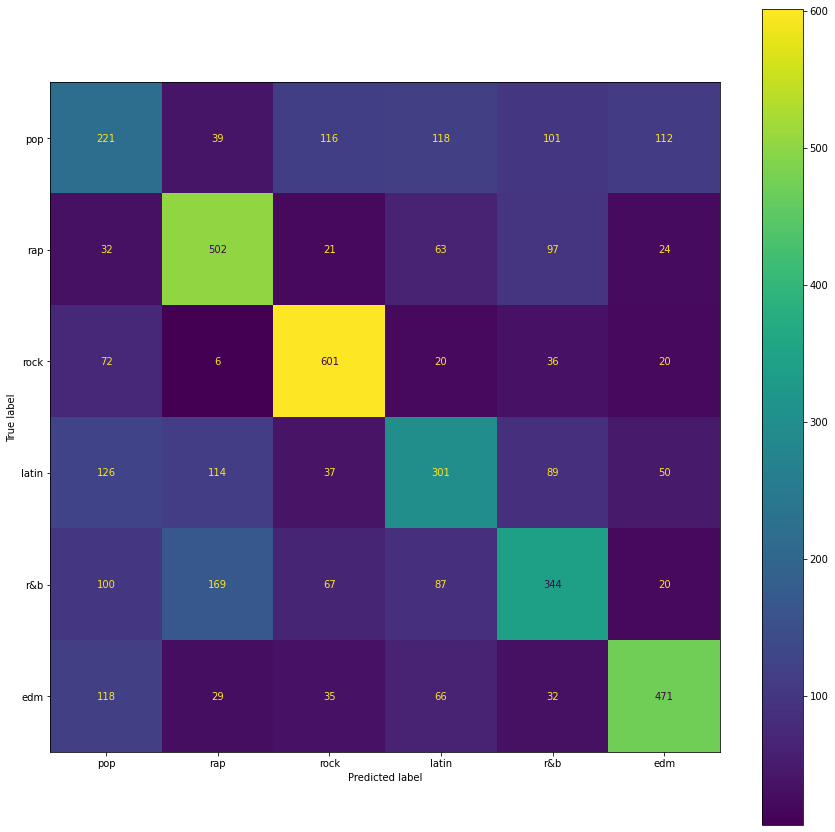

In [60]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## KNN on important features

Let's try to consider only the features with high `feature importance` in both random forest and decision trees and use them for the KNN classifier

In [64]:
feature_importances = feature_importances_dt + feature_importances_rf
print(feature_importances.sort_values(ascending=False))

speechiness         0.315106
danceability        0.289149
tempo               0.282790
energy              0.180037
instrumentalness    0.170355
duration_ms         0.166042
loudness            0.162947
valence             0.152539
acousticness        0.141679
liveness            0.073387
key                 0.049984
mode                0.015984
dtype: float64


In [65]:
res = []
for n_features in tqdm(np.arange(1, len(feature_importances))):
    important_columns = feature_importances.sort_values(ascending=False).index[:n_features]
    important_data = songs_data[important_columns]
    important_data_train, important_data_test, important_target_train, important_target_test = train_test_split(important_data, songs_target, test_size=0.15, random_state=0)
    # cross validation
    for k in np.arange(1,40):
        knn_model = KNeighborsClassifier(n_neighbors=k)
        er = cross_val_score(knn_model,important_data_train,important_target_train,cv=5)
        res.append({'n_feat': n_features, 'K':k, 'err_rate': er.mean()})


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [24:44<00:00, 134.92s/it]


In [66]:
# find best k for each number of features
results_df = pd.DataFrame(res)
results_df = results_df.sort_values('err_rate', ascending=False)
results_df = results_df.groupby('n_feat').head(1)
results_df = results_df.reset_index(drop=True)
results_df

,n_feat,K,err_rate
0,9,36,0.501069
1,8,38,0.499406
2,10,30,0.495248
3,7,33,0.486653
4,11,38,0.472356
5,6,33,0.472158
6,5,26,0.458218
7,4,33,0.447485
8,3,38,0.423129
9,2,39,0.344515


In [67]:
important_columns = feature_importances.sort_values(ascending=False).index[:9]
important_data = songs_data_train[important_columns]
important_data_train, important_data_test, important_target_train, important_target_test = train_test_split(important_data, songs_target_train, test_size=0.15, random_state=0)

knn_model = KNeighborsClassifier(n_neighbors=32)
knn_model.fit(important_data_train, important_target_train)
y_pred = knn_model.predict(important_data_test)
accuracy = accuracy_score(important_target_test, y_pred)
print(accuracy)

0.5032051282051282


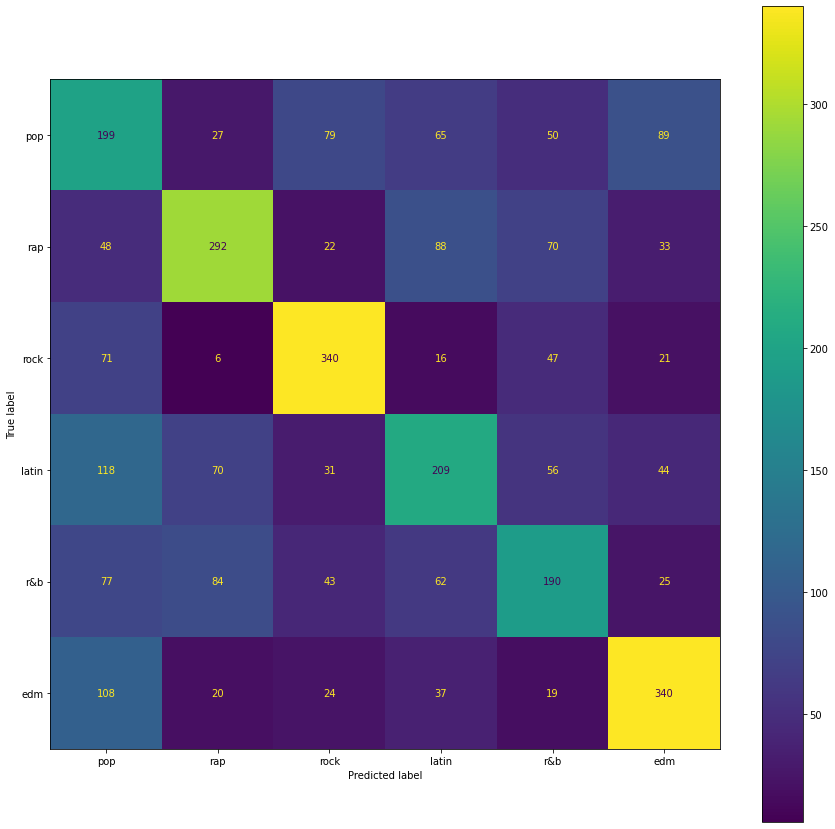

In [68]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(important_target_test,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Support Vector Machine

In [69]:
# Support Vector Machine
clf = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=4)
clf.fit(songs_data_train, songs_target_train)
y_pred = clf.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.5175044883303411


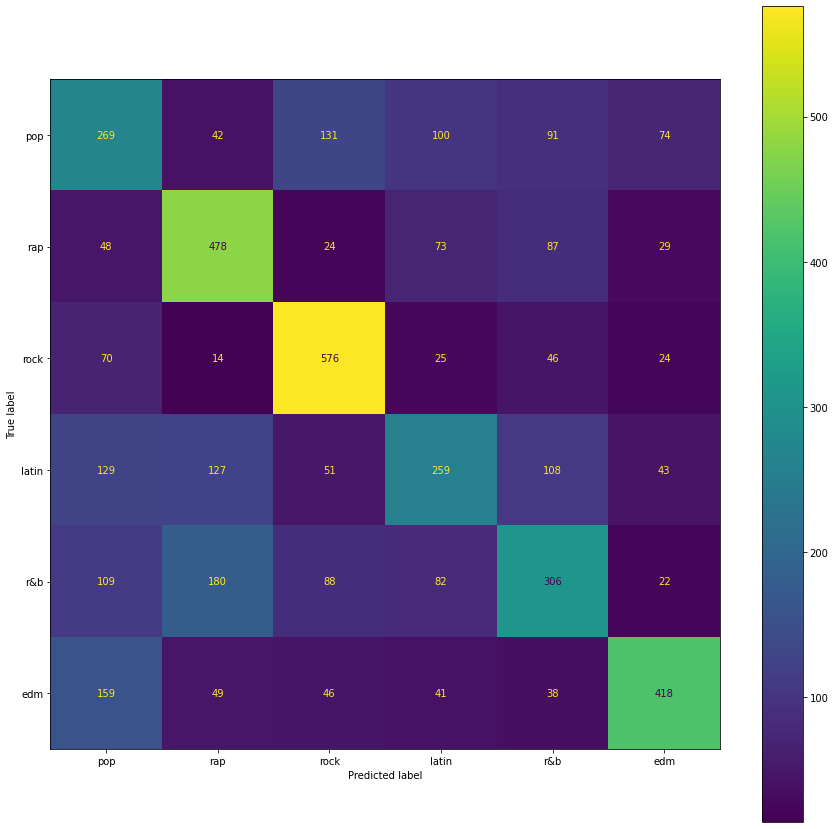

In [70]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Multiclass Logistic Regression

In [71]:
mlr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000)
mlr.fit(songs_data_train, songs_target_train)
y_pred = mlr.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.4762118491921005


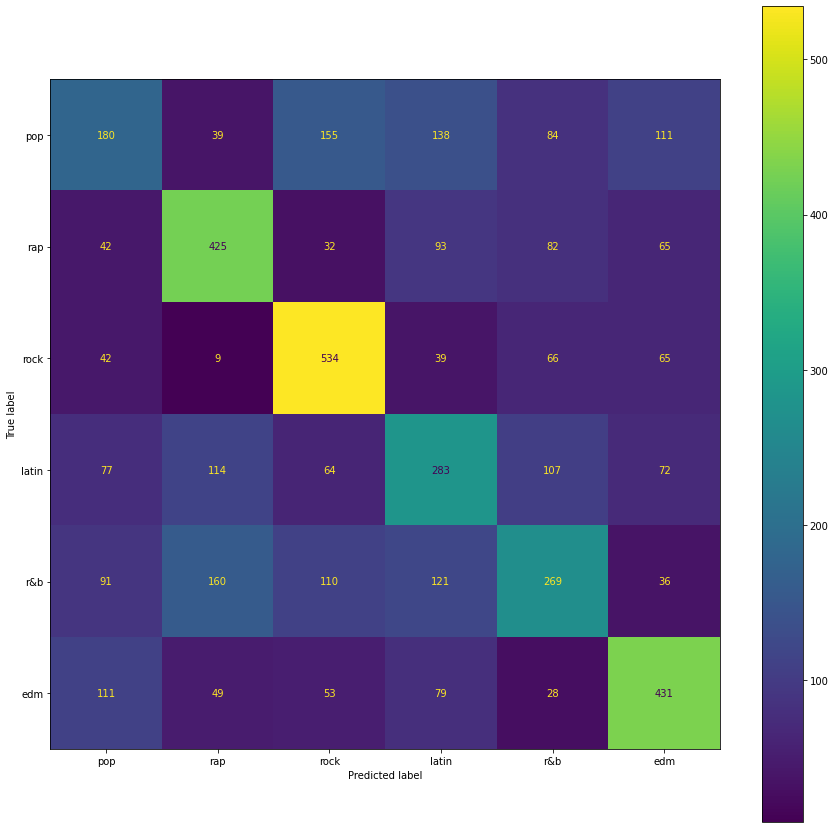

In [73]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## AdaBoost


In [74]:
# AdaBoost
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_model, n_estimators=50, learning_rate=1, random_state=42)
adaboost_model.fit(songs_data_train, songs_target_train)
y_pred = adaboost_model.predict(songs_data_val)


accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.4903500897666068


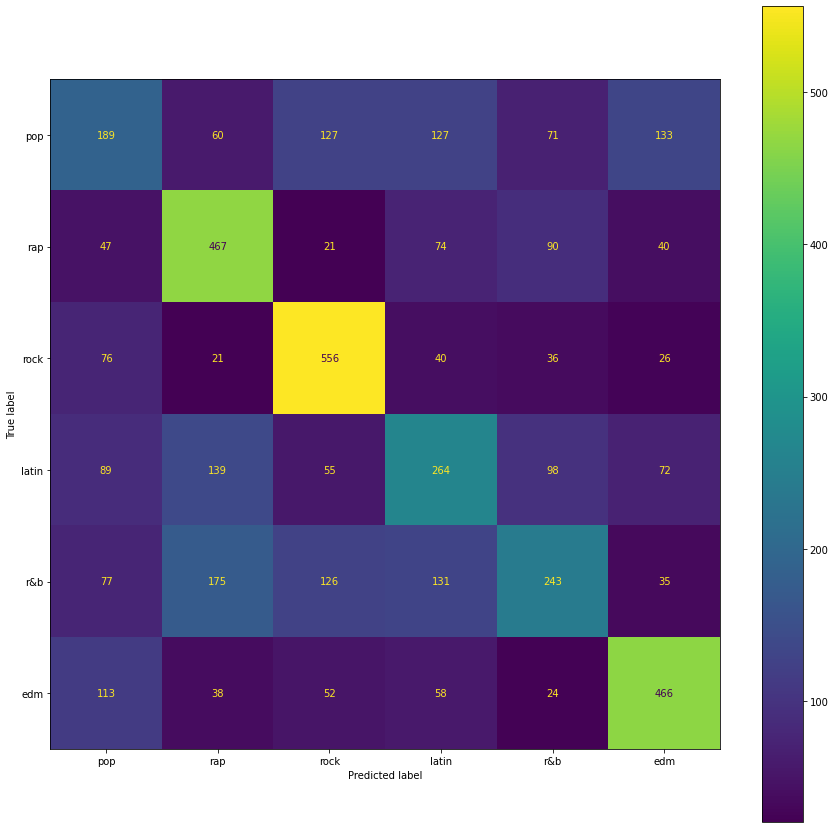

In [76]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Bootstrap Aggregating

In [77]:
#Bagging (Bootstrap Aggregating)
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_model, n_estimators=50, random_state=42)
bagging_model.fit(songs_data_train, songs_target_train)
y_pred = bagging_model.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.5412926391382405


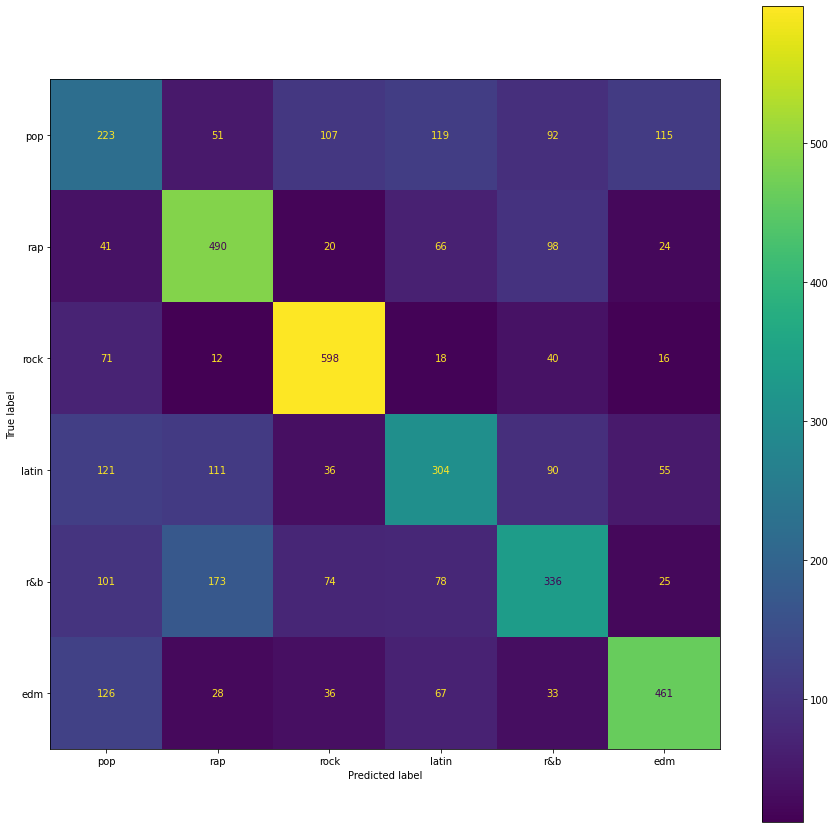

In [78]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_val,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## TO DO

XGBoost